In [2]:
# 미국 Boston 지역의 집값 data 불러오기
import pandas as pd
house = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                     'python-machine-learning-book-2nd-edition'
                     '/master/code/ch10/housing.data.txt',header=None,sep='\s+')
house.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS','NOX', 'RM', 'AGE', 'DIS', 'RAD','TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
house.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

미국 Boston 지역의 집값에 대한 자료입니다. MEDV(집가격, 단위 $1000)가 y변수이며 13개 특성변수로 MEDV를 회귀분석을 통해 예측하고자 하는 모델을 제시하세요. 데이터에 대한 EDA를 진행하고 Visualization을 제시하세요. Linear Regession과 RANSACRegressor도 함께 사용하여, 두 모델을 비교하고 해석하세요. 또한 Elastic Net을 nested cross validation을 적용하여 최선의 모형을 산출하세요. 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, RANSACRegressor, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

In [4]:
#출처 : https://teddylee777.github.io/scikit-learn/scikit-learn-linear-with-regularizations 수경님이 찾으신 코드와 아마 동일
my_predictions = {} #
my_pred = None
my_actual = None
my_name = None

SEED=30

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo']

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.xlabel('index', fontsize=20) #수정한 부분
    plt.ylabel('MEDV', fontsize=20) #수정한 부분
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def add_model(name_, pred, actual):
    global my_predictions, my_pred, my_actual, my_name
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    r2_1 = r2_score(pred, actual) #수정한 부분
    if r2_1 > -1: #-1400나 -700 같은 r2 값을 가진 모델도 있어서 가독성에 방해가 될 것 같아서 그런 애들을 지워줌
        my_predictions[name_] = r2_1    

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_all():
    global my_predictions, my_pred, my_actual, my_name
    
    plot_predictions(my_name, my_pred, my_actual)
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1])
    
    df = pd.DataFrame(y_value, columns=['model', 'r2_1']) #수정한 부분 mse -> r2_1
    print(df)
    min_ = df['r2_1'].min() - 1 # "
    max_ = df['r2_1'].max() + 1 # "
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['r2_1'], height=0.3)
    
    for i, v in enumerate(df['r2_1']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('r2 scores', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

<h2>EDA and Data Preprocessing</h2>

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Data Report
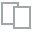
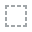
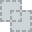
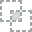
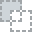
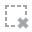
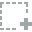
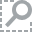
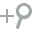
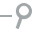
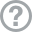
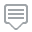
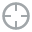
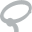
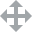
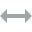
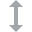
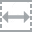
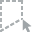
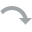
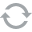
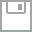
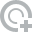
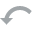
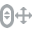
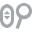
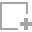
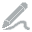
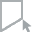
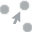
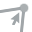
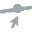

In [5]:
#EDA
from dataprep.eda import create_report

data_report = create_report(house, title='Data Report')
data_report

In [6]:
house_column = house.columns.to_list()
X = house[house_column[0:13]]
y = house[house_column[-1]]

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=64)

In [7]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [8]:
house.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677082   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

In [9]:
# 정규화
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

In [10]:
#Graph Drawer
def draw_graph(name_, y_pred, y_test):
    df = pd.DataFrame({'prediction': y_pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)
    
    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.xlabel('index', fontsize=20)
    plt.ylabel('MEDV', fontsize=20)
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

<h2>Linear Regression</h2>

In [11]:
# Regression 적용
linear_reg = LinearRegression().fit(X_train, y_train)

In [12]:
print(linear_reg.coef_) #각 Attribute에 대한 β 계수 (Attribute가 하나일 경우 기울기와 같음)

[-1.03087067  1.0674218  -0.03987312  0.49329328 -1.99144255  2.94762884
 -0.31757837 -3.03675664  2.55089541 -2.14790444 -2.07409572  0.86001734
 -3.1451715 ]


In [13]:
print(linear_reg.intercept_) #절편

22.117404129793513


In [22]:
y_pred = linear_reg.predict(X_test) #모델에 test set 넣어서 예측값들 y_pred에 저장
y_pred

array([15.7397051 , 24.16105645, 16.76497544, 35.14819356, 19.85035486,
       22.6888223 , 25.74197377, 20.38612923, 17.12900108, 33.12026823,
       27.79175557, 31.29490098, 30.55361727, 30.46127829, 25.00854901,
       15.7052054 , 14.95904692, 18.34907162, 20.68888693, 18.86496975,
       20.36134345, 34.69093833, 11.29386193, 21.57506203, 38.84306209,
       25.44969557, 26.12001898, 19.86197288, 19.24538605, 30.31655797,
       20.05654646, 25.01688226, 19.14455839, 20.18411406, 35.43395535,
       24.23261094, 25.78984126, 23.81659057, 16.63060575, 37.91067909,
       22.94797473, 27.3644135 , 28.46592826, 26.7571765 , 13.45385699,
       20.88573985, 23.03866485, 20.44969628, 25.07448915, 12.82512664,
       24.37452373, 19.66319838, 27.8159117 , 33.61392039, 20.2081853 ,
       30.36256865, 17.96599306, 12.69843494, 37.59282519,  9.40643303,
       21.32800023,  4.94965017, 25.20610943, 19.90357502, 11.68434378,
       32.40271399, 17.12745876,  8.13830613, 24.53240974, 12.73

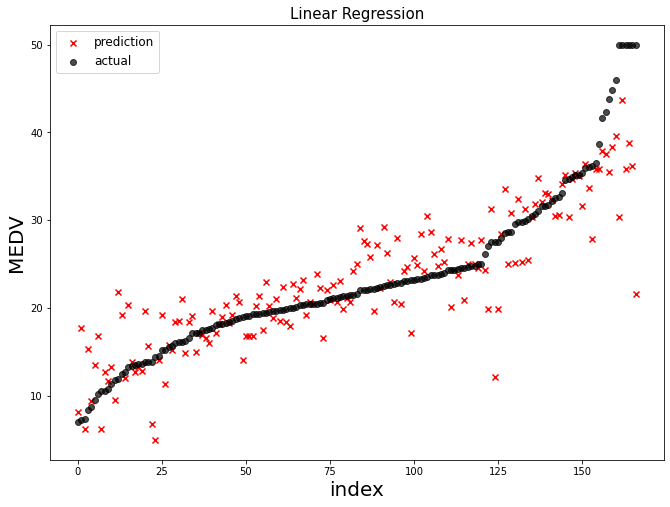

In [15]:
draw_graph('Linear Regression', y_pred, y_test) #draw_graph 함수 사용해서 실제값과 예측값 그리기
                                                #X축 index, Y축 예측값

In [16]:
#세 가지 Error Metric (MSE, R2, MAE)
print('Mean Squared Error of RANSAC regression model: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('R2 score of RANSAC regression model: {:.3f}'.format(r2_score(y_test, y_pred)))
print('Mean Absolute Error of RANSAC regression model: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))

Mean Squared Error of RANSAC regression model: 23.632
R2 score of RANSAC regression model: 0.721
Mean Absolute Error of RANSAC regression model: 3.193


<h2>RANSAC Regressor</h2>

In [17]:
RANSAC_reg = RANSACRegressor(random_state=42).fit(X_train, y_train) #RANSAC Regressor 모델 생성 및 훈련

In [18]:
RANSAC_reg.get_params()

{'base_estimator': None,
 'is_data_valid': None,
 'is_model_valid': None,
 'loss': 'absolute_loss',
 'max_skips': inf,
 'max_trials': 100,
 'min_samples': None,
 'random_state': 42,
 'residual_threshold': None,
 'stop_n_inliers': inf,
 'stop_probability': 0.99,
 'stop_score': inf}

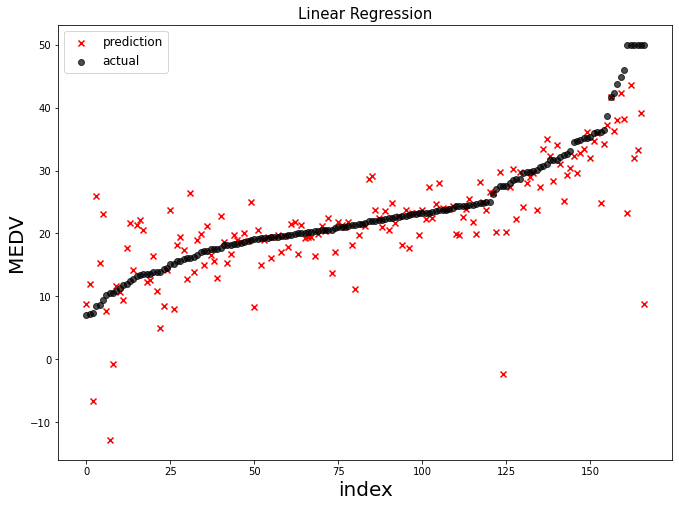

In [19]:
y_pred = RANSAC_reg.predict(X_test) #RANSAC Regressor 모델의 예측치 y_pred에 저장
draw_graph('Linear Regression', y_pred, y_test) #그래프 그리기

In [20]:
print('Mean Squared Error of RANSAC regression model: {:.3f}'.format(mean_squared_error(y_test, y_pred)))
print('R2 score of RANSAC regression model: {:.3f}'.format(r2_score(y_test, y_pred)))
print('Mean Absolute Error of RANSAC regression model: {:.3f}'.format(mean_absolute_error(y_test, y_pred)))

Mean Squared Error of RANSAC regression model: 46.177
R2 score of RANSAC regression model: 0.455
Mean Absolute Error of RANSAC regression model: 3.972


<h2>Elastic Net</h2>

In [24]:
#중첩 k-fold
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=0)

est = ElasticNet(random_state=SEED,max_iter=5000,tol=0.1)  #max_iter와 tol 파라미터는 워닝이 계속 떠서 방지를 위해 추가
                                                            #추가하지 않으면 수렴이 되지않는다는 경고가 많이 뜸

grid = dict()
grid['alpha'] = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
grid['l1_ratio'] = [0, 0.25, 0.5, 0.75, 1]

gs = GridSearchCV(est, grid, scoring='r2', cv=inner_cv) #Estimater가 Elastic Net, 경우의 수는 grid 변수에 있는 값들을 넘겨주고
                                                        #Scoring 방식은 r2를 사용, cross validation은 inner_cv를 사용
scores = cross_val_score(gs, X_train, y_train, scoring='r2', cv=outer_cv) #Cross validation 하나 더 중첩 (Nested Cross Validation)
print('r2 score mean: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) #10개의 outer fold의 best score의 mean 값과 표준 편차

#그리드서치를 사용해서 최적의 parameter를 구한결과: alpha = 0.01, l1_ratio = 0, 즉 ridge (L2 Regularization)만 사용하는 것이 더 정확하다

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10753.796539638462, tolerance: 2210.39319262295
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10960.173745044596, tolerance: 2255.902229508197
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9335.972872422828, tolerance: 1916.060602459016
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2556.8436557966643, tolerance: 1916.060602459016
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2866.748114139034, tolerance: 2022.935229508197
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2527.369074371881, tolerance: 2194.2112459016394
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Con

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2868.7172478373964, tolerance: 2232.744442622951
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2938.1093781228715, tolerance: 2213.8029836065575
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2405.1803022820854, tolerance: 1930.1705040983607
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: 

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2755.076069107387, tolerance: 2016.5675532786886
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2651.405443589208, tolerance: 1938.0981106557379
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2607.047972653231, tolerance: 2008.2952295081968
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Co

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3565.27961857193, tolerance: 2221.104668032787
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3434.8712287645426, tolerance: 2098.483520491803
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2847.863714425079, tolerance: 1917.1252295081968
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4878.186569953837, tolerance: 2098.7972622950824
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4949.121014432655, tolerance: 2124.691192622951
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5027.545927708748, tolerance: 2015.1150491803282
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Con

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8133.372170220283, tolerance: 2002.676307377049
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8911.565221864654, tolerance: 2189.134110655738
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8451.49412690423, tolerance: 2021.5039508196724
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conve

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9629.48360767191, tolerance: 1971.6889631147542
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10755.575516771287, tolerance: 2215.4483073770493
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9927.784647832399, tolerance: 2041.8473893442629
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Co

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3040.5444392001386, tolerance: 2215.4483073770493
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2476.614262936756, tolerance: 2041.8473893442629
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2445.5368792114714, tolerance: 2152.507147540983
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: C

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2251.3218132509855, tolerance: 2036.9916885245905
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2458.9017815700477, tolerance: 2198.1802131147538
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2146.831281620973, tolerance: 1828.9673114754096
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: 

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2323.198263110955, tolerance: 1703.53531147541
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2305.5349316951647, tolerance: 1917.4040778688527
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2060.42998663018, tolerance: 1938.6863401639348
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Conv

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2967.641750513206, tolerance: 2055.1860244897957
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2692.6950473239403, tolerance: 1938.3260816326533
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3284.7973569547057, tolerance: 2110.1695346938773
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: 

r2 score mean: 0.710 +/- 0.112


C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13816.913207830366, tolerance: 2.8400987315634216
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11546.993898517878, tolerance: 2.8400987315634216
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6854.933340990348, tolerance: 2.8400987315634216
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: 

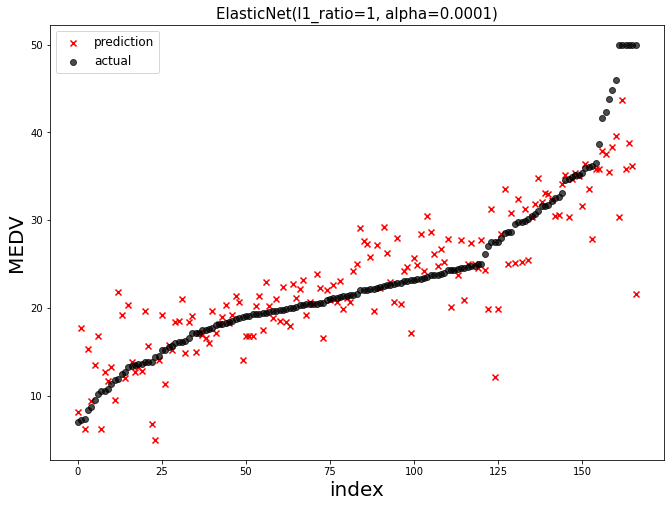

                                      model      r2_1
0           ElasticNet(l1_ratio=0, alpha=1) -0.181921
1        ElasticNet(l1_ratio=0.25, alpha=1) -0.139988
2         ElasticNet(l1_ratio=0.5, alpha=1) -0.081906
3      ElasticNet(l1_ratio=0.25, alpha=100)  0.000000
4       ElasticNet(l1_ratio=0.5, alpha=100)  0.000000
5      ElasticNet(l1_ratio=0.75, alpha=100)  0.000000
6       ElasticNet(l1_ratio=0.75, alpha=10)  0.000000
7         ElasticNet(l1_ratio=1, alpha=100)  0.000000
8          ElasticNet(l1_ratio=1, alpha=10)  0.000000
9        ElasticNet(l1_ratio=0.75, alpha=1)  0.020114
10          ElasticNet(l1_ratio=1, alpha=1)  0.193167
11        ElasticNet(l1_ratio=0, alpha=0.1)  0.508839
12     ElasticNet(l1_ratio=0.25, alpha=0.1)  0.518171
13      ElasticNet(l1_ratio=0.5, alpha=0.1)  0.527844
14     ElasticNet(l1_ratio=0.75, alpha=0.1)  0.537885
15        ElasticNet(l1_ratio=1, alpha=0.1)  0.548303
16       ElasticNet(l1_ratio=0, alpha=0.01)  0.583234
17    ElasticNet(l1_ratio=0.

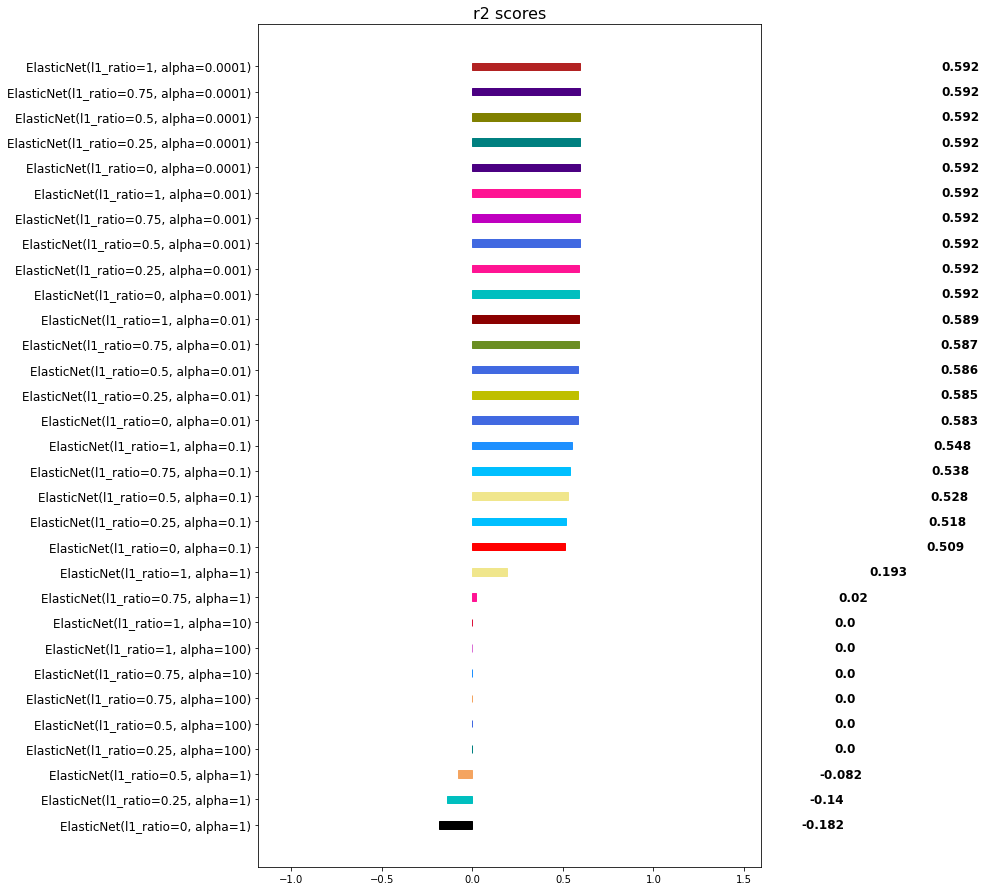

In [25]:
#모든 경우의 수에서 r2 점수를 찾아봤습니다 + 시각화
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
ratios = [0, 0.25, 0.5, 0.75, 1]

for ratio in ratios: #ratios에 저장되어 있는 모든 ratio와
    for alpha in alphas: #alphas에 저장되어 있는 모든 alphas에 대해 다음을 수행:
        elasticnet = ElasticNet(alpha=alpha, l1_ratio=ratio, random_state=SEED) #Elastic Net 모델 생성
        elasticnet.fit(X_train, y_train) #Train
        pred = elasticnet.predict(X_test) #예측값 pred에 저장
        add_model('ElasticNet(l1_ratio={}, alpha={})'.format(ratio, alpha), pred, y_test) #add_model 함수를 이용해서 모델을 추가함
plot_all() #그래프 그리기

#분석:
#alpha 값이 커질수록 더 낮은 점수가 나타나는 경향, l1 ratio 1 -> 0.75 -> 0.5 -> 0.25 순으로 점수가 낮아짐 (항상) 따라서
#그냥 Lasso (L1 Regularization)만 사용하는 것이 더 좋은 점수를 나타냄
#GridSearchCV와는 다른 결과

In [26]:
elsticnet_best = ElasticNet(alpha=0.0001, l1_ratio=1) #위에서 best score를 기록한 alpha와 l1 ratio를 사용한 elastic net 모델 생성
elsticnet_best.fit(X_train, y_train)

elsticnet_25 = ElasticNet(alpha=1, l1_ratio=0.25) #l1 ratio가 0.25, alpha가 1인 elastic net 모델
elsticnet_25.fit(X_train, y_train)

elsticnet_75 = ElasticNet(alpha=1, l1_ratio=0.75) #l1 ratio가 0.75, alpha가 1인 elastic net 모델
elsticnet_75.fit(X_train, y_train)

#l1 ratio에 따른 차이를 살펴보기위해

ElasticNet(alpha=1, l1_ratio=0.75)

In [27]:
def plot_coef(columns, coef): #Attribute 별로 coefficient 값 시각화하는 함수
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(9, 7))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'])
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    plt.show()

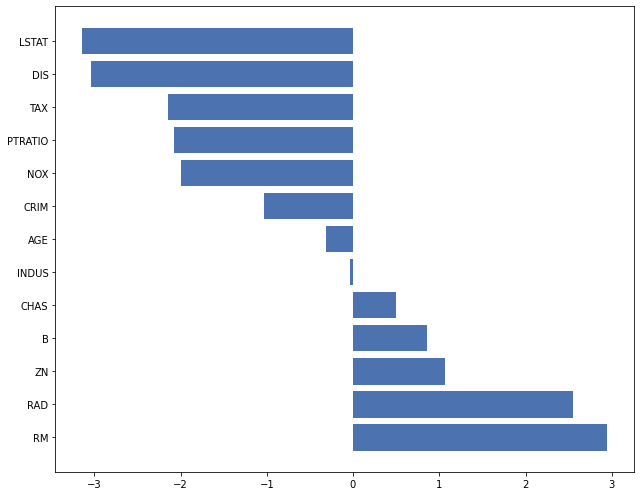

array([-1.03058499,  1.06710196, -0.0399793 ,  0.49325482, -1.99107415,
        2.94774986, -0.31739201, -3.03607784,  2.54927975, -2.14652985,
       -2.07394012,  0.85992901, -3.14522005])

In [28]:
plot_coef(house.columns[0:13], elsticnet_best.coef_) #제일 높은 r2 score의 elastic net model(alpha=0.001, l1_ratio=1)의 attribute coefficient 시각화
elsticnet_best.coef_

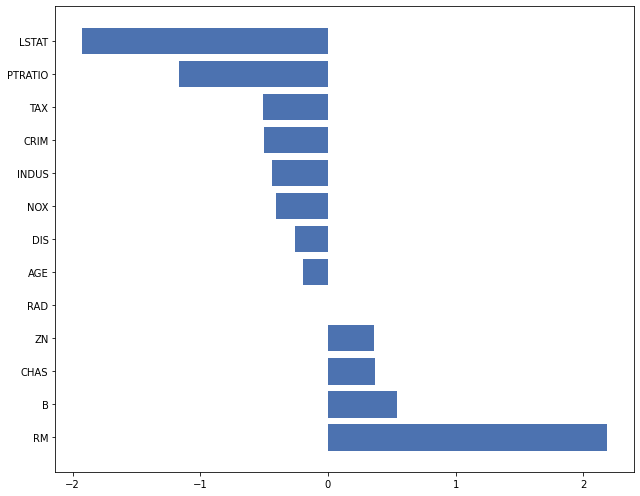

In [29]:
plot_coef(house.columns[0:13], elsticnet_25.coef_) #l1 ratio가 0.25인 모델의 coefficients

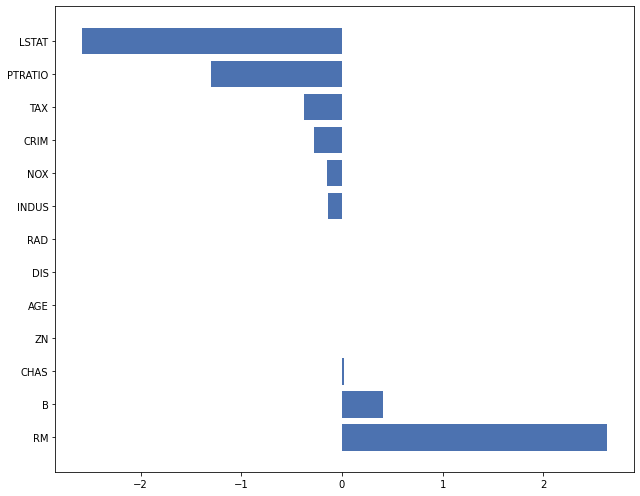

In [30]:
plot_coef(house.columns[0:13], elsticnet_75.coef_) #l1 ratio가 0.75인 모델의 coefficients

In [31]:
cv = KFold(n_splits=8, shuffle=True, random_state=0)

gs2 = GridSearchCV(est, grid, scoring='r2', cv=inner_cv)
gs2.fit(X_train, y_train)

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11614.791062728422, tolerance: 2381.1307453874538
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11086.738083492532, tolerance: 2275.7867527675276
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11020.646731246128, tolerance: 2264.2535424354246
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530:

C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3086.8181243838176, tolerance: 2381.1307453874538
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2938.0130586062955, tolerance: 2275.7867527675276
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3144.929831984308, tolerance: 2264.2535424354246
  model = cd_fast.enet_coordinate_descent(
C:\Users\RetepMil\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: 

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=ElasticNet(max_iter=5000, random_state=30, tol=0.1),
             param_grid={'alpha': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
             scoring='r2')

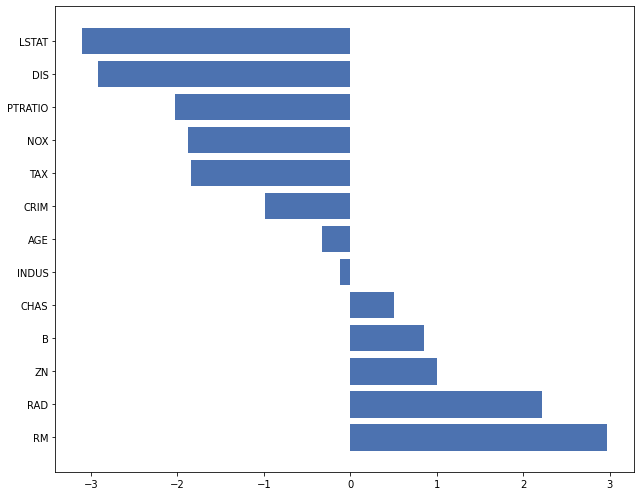

array([-0.99028424,  1.00644618, -0.1219384 ,  0.50642864, -1.88318931,
        2.97220382, -0.32810077, -2.91769591,  2.21441956, -1.84026141,
       -2.03308747,  0.85686313, -3.10733873])

In [32]:
plot_coef(house.columns[0:13], gs2.best_estimator_.coef_)
#alpha와 l1_ratio값은 다르지만, (위에서)일일히 값을 넣어서 구한 best parameter의 elastic model의 coefficient가 매우 유사하다
gs2.best_estimator_.coef_

<h2>결론</h2>
1. RANSAC regressor을 적용시키지 않은 평범한 linear regression 모델의 정확도가 더 높았다
<br>
2. GridSearchCV 결과 이 데이터 셋의 Elastic Net 모델 best parameter는 alpha = 0.01, l1_ratio = 0 이었다 (nested cross validation GridSearch에서 best parameter값을 구하는 방법을 찾지못함...)
<br>
(alpha나 l1값을 더 정밀하게 구하려면 linspace를 사용하면 될 것 같다)
<br>
** alpha와 l1_ratio값들을 일일히 다 넣어서 비교한 elastic model의 r2 score들을 살펴보면 alpha 값이 커질수록 더 낮은 점수가 나타나는 경향이 있으며 l1 ratio는 1 -> 0.75 -> 0.5 -> 0.25 순으로 점수가 낮아졌다. GridSearchCV의 결과와 비교하면 l1_ratio는 반대의 결과, alpha의 값은 다르게 나타났다.
<br>